In [19]:
import torch
import numpy as np
import pandas as pd
import h5py
import re
import warnings
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Set device (use MPS for Mac, CUDA for GPU, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
# 📌 Step 3: Load the Lotka-Volterra Data
file_path = "../lotka_volterra_data.h5"

with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
    time_points = f["time"][:]  # Shape: (100,)

# Convert to Pandas DataFrame for visualization
num_samples = 10  # Reduce to 10 samples for easier viewing
data_dict = {
    "Time": np.tile(time_points, num_samples),
    "Prey Population": trajectories[:num_samples, :, 0].flatten(),
    "Predator Population": trajectories[:num_samples, :, 1].flatten(),
    "Sample ID": np.repeat(range(num_samples), len(time_points)),
}

df = pd.DataFrame(data_dict)

In [29]:
df

,Time,Prey Population,Predator Population,Sample ID
0,0.000000,0.949917,1.040624,0
1,2.020202,0.740551,0.779542,0
2,4.040404,0.682246,0.564390,0
3,6.060606,0.716674,0.407644,0
4,8.080808,0.824511,0.300283,0
...,...,...,...,...
995,191.919192,0.101669,0.417827,9
996,193.939394,0.102054,0.308723,9
997,195.959596,0.112150,0.228933,9
998,197.979798,0.131614,0.171448,9


In [28]:
print(df[df['Sample ID'] == 0])


          Time  Prey Population  Predator Population  Sample ID
0     0.000000         0.949917             1.040624          0
1     2.020202         0.740551             0.779542          0
2     4.040404         0.682246             0.564390          0
3     6.060606         0.716674             0.407644          0
4     8.080808         0.824511             0.300283          0
..         ...              ...                  ...        ...
95  191.919192         2.150174             0.435865          0
96  193.939394         2.249839             0.450019          0
97  195.959596         2.322866             0.472970          0
98  197.979798         2.357413             0.502543          0
99  200.000000         2.347119             0.535270          0

[100 rows x 4 columns]


In [18]:
df['Sample ID'] = 1

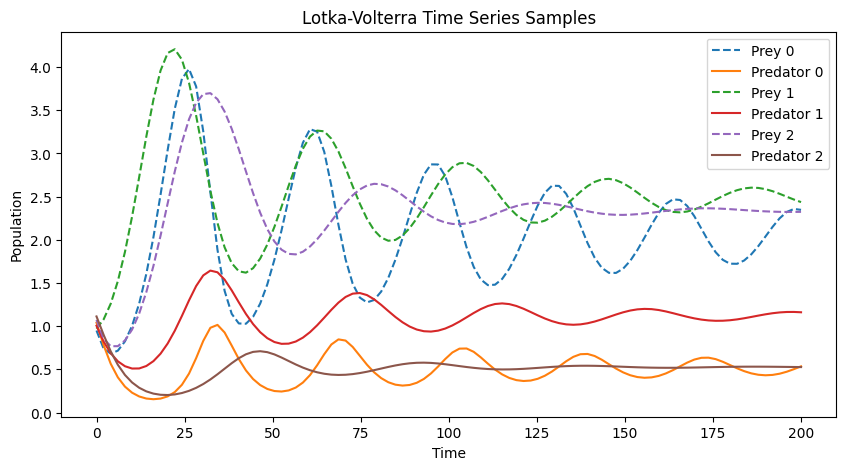

In [5]:
# Visualizing sample trajectories
plt.figure(figsize=(10, 5))
for sample_id in range(3):
    sample_data = df[df["Sample ID"] == sample_id]
    plt.plot(sample_data["Time"], sample_data["Prey Population"], label=f"Prey {sample_id}", linestyle="dashed")
    plt.plot(sample_data["Time"], sample_data["Predator Population"], label=f"Predator {sample_id}")

plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Lotka-Volterra Time Series Samples")
plt.show()

In [6]:
# 📌 Step 4: Load the Qwen2.5 Model & Tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)
tokenizer.padding_side = "left"  # Fix padding issue

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# 📌 Step 5: Preprocess Data for the Model
def format_input(sample_index, num_steps=20):
    """
    Converts a time-series sequence into text format for Qwen2.5.
    """
    prey = trajectories[sample_index, :num_steps, 0]
    predator = trajectories[sample_index, :num_steps, 1]

    formatted_text = "Given the following time series, predict the next values:\n"
    formatted_text += ";".join([f"{prey[i]:.2f},{predator[i]:.2f}" for i in range(num_steps)])

    return formatted_text

# Select a sample to predict
sample_index = 0
input_text = format_input(sample_index)
print("📝 Model Input:\n", input_text)

📝 Model Input:
 Given the following time series, predict the next values:
0.95,1.04;0.74,0.78;0.68,0.56;0.72,0.41;0.82,0.30;1.00,0.23;1.26,0.19;1.61,0.16;2.03,0.15;2.52,0.16;3.04,0.19;3.52,0.24;3.86,0.32;3.98,0.45;3.78,0.63;3.26,0.83;2.55,0.98;1.88,1.02;1.41,0.93;1.14,0.78


In [11]:

# 📌 Step 6: Tokenize and Generate Predictions
input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)["input_ids"]
input_ids = input_ids.to(device)

with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=20,  # Number of values to predict
        do_sample=True,
        top_k=50,
        temperature=0.9,
    )

In [12]:
# 📌 Step 7: Decode and Extract Numeric Predictions
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("\n🔍 Raw Model Output:\n", generated_text)

# Extract numeric values
def extract_numbers(text):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    return [float(num) for num in numbers]

predicted_values = extract_numbers(generated_text)



🔍 Raw Model Output:
 Given the following time series, predict the next values:
0.95,1.04;0.74,0.78;0.68,0.56;0.72,0.41;0.82,0.30;1.00,0.23;1.26,0.19;1.61,0.16;2.03,0.15;2.52,0.16;3.04,0.19;3.52,0.24;3.86,0.32;3.98,0.45;3.78,0.63;3.26,0.83;2.55,0.98;1.88,1.02;1.41,0.93;1.14,0.78;0.88,0.62;
To make it more challenging, we have an


In [13]:
# 📌 Step 8: Compare Predictions to Ground Truth
# Get actual values for the next steps
true_values = trajectories[sample_index, 20:30, :].flatten()  # Next 10 steps

# Ensure predicted values match length of true values
predicted_values = predicted_values[:len(true_values)]

# Metrics
mse = mean_squared_error(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)


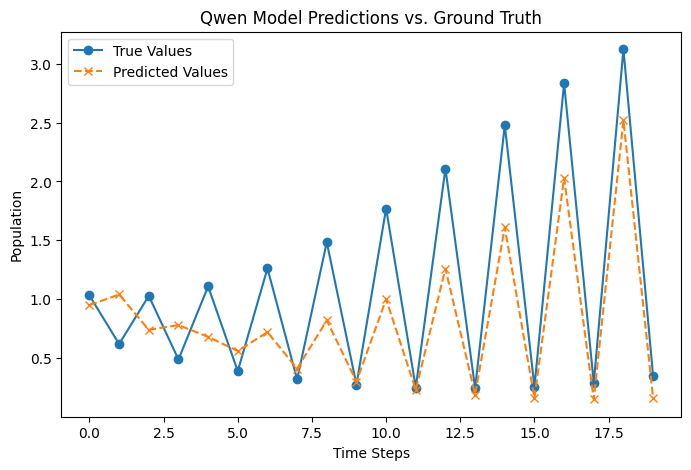

In [14]:
# 📌 Step 9: Visualize Predictions vs. Ground Truth
plt.figure(figsize=(8, 5))
plt.plot(range(len(true_values)), true_values, label="True Values", marker="o")
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Values", linestyle="dashed", marker="x")

plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.legend()
plt.title("Qwen Model Predictions vs. Ground Truth")
plt.show()

In [15]:
# 📌 Step 10: Print Evaluation Metrics
print(f"\n **Evaluation Metrics:**")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R² Score: {r2:.4f}")


 **Evaluation Metrics:**
 - Mean Squared Error (MSE): 0.2229
 - Mean Absolute Error (MAE): 0.3700
 - R² Score: 0.7291
